Plot the region chosen: fiducialID= 1447

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import pandas as pd
import copy
import healpy as hp
import lsst.sims.maf.metricBundles as metricBundles
repoDir= os.getcwd()
os.chdir(os.path.join(repoDir , '..' ))
repoDir= os.getcwd()
from intermediates import *
from plotFunctions import *

In [2]:
path= '/Volumes/Transcend/'
path2= '2017-01-11/coaddM5Analysis_nside256_withDustExtinction_14pixelRadiusForMasking_rBand_minion1016_fullSurveyPeriod_directory/'
path3= 'maskedCoaddData/'
os.chdir(path+path2+path3)

# get the saved files
filenames = ['coaddM5Data_masked_r_NoDither.npz', 
             'coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz']

coaddBundle= {}
for i in range(len(filenames)):
    mB = metricBundles.createEmptyMetricBundle()
    mB.read(filenames[i])
    dithStrategy= mB.metadata.strip()   # key is assigned to be the same as dithStrategy
    print 'Filename for ' + dithStrategy + ': ', filenames[i]
    print ''

    coaddBundle[dithStrategy]= mB

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for NoDither:  coaddM5Data_masked_r_NoDither.npz

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for RandomDitherFieldPerVisit:  coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz



### Read in OpSim data.

In [3]:
dbpath = path+'minion_1016_sqlite_new_dithers.db'
simdata= getSimData(dbpath, 'r', extraCols= [], newAfterburner= True)

In [4]:
help(findRegionPixels)

Help on function findRegionPixels in module intermediates:

findRegionPixels(fiducialID, simdata, nside, disc, FOV_radius)
    Find the region (disc or rectangular) based on the specified field ID.
    
    Required Parameters
    -------------------
    * fiducialID: int: fieldID for the FOV on which to base the region.
    * simdata: np.array: array containing OpSim columns (must have fieldID, fieldRA, fieldDec).
    * nside: int: HEALPix resolution parameter.
    * disc: bool: set to true if want disc-like region; False for rectangular.
    * FOV_radius: float: radius of the FOV in radians.



### Get the pixels for the disc and nondisc with fiducialID= 1447.

In [5]:
fID= 1447
fiducialRA, fiducialDec, discPixels= findRegionPixels(fiducialID= fID, simdata= simdata, nside= 256, 
                                                      disc= True, FOV_radius= 0.0305)
fiducialRA2, fiducialDec2, nondiscPixels= findRegionPixels(fiducialID= fID, simdata= simdata, nside= 256, 
                                                      disc= False, FOV_radius= 0.0305)

In [6]:
print fiducialRA, fiducialDec
print fiducialRA2, fiducialDec2

1.641324 -0.496320774815
1.641324 -0.469907


#### Plot the full region first.

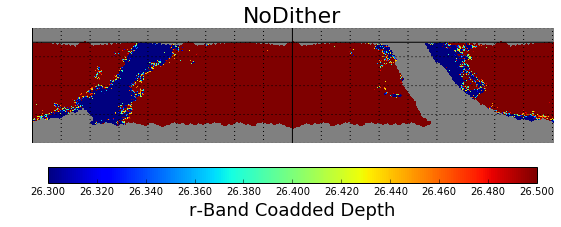

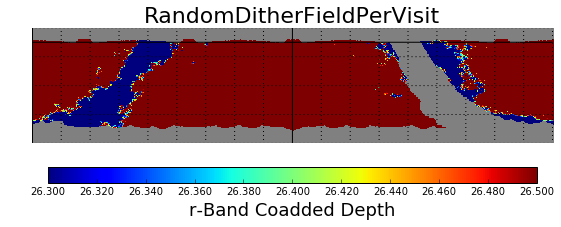

In [7]:
for dither in coaddBundle:
    plt.clf()
    hp.cartview(coaddBundle[dither].metricValues.filled(coaddBundle[dither].slicer.badval), 
                flip='astro', rot=(0,0,0) ,
                lonra= [-180,180], latra= [-70,10],
                min= 26.3, max= 26.5, title= '', cbar=False)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.title(dither, size= 22)
    ax = plt.gca()
    im = ax.get_images()[0]
    fig= plt.gcf()
    cbaxes = fig.add_axes([0.1, 0.25, 0.8, 0.04]) # [left, bottom, width, height]
    cb = plt.colorbar(im,  orientation='horizontal',
                format= '%.3f', cax = cbaxes) 
    cb.set_label('r-Band Coadded Depth', fontsize=18)
    plt.show()

#### Plot the nonDisc region -- artificially colored.

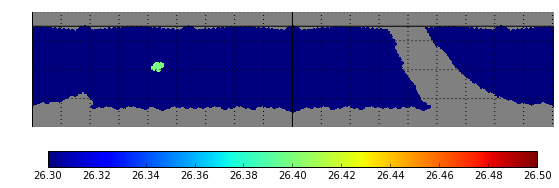

In [8]:
check= copy.deepcopy(coaddBundle['NoDither'])
check.metricValues.data[:]= 0
check.metricValues.data[nondiscPixels]= 26.4
    
plt.clf()
hp.cartview(check.metricValues.filled(check.slicer.badval), 
            flip='astro', rot=(0,0,0) ,
            lonra= [-180,180], latra= [-70,10],
            min= 26.3, max= 26.5, title= '', cbar=False)
hp.graticule(dpar=20, dmer=20, verbose=False)
ax = plt.gca()
im = ax.get_images()[0]
fig= plt.gcf()
cbaxes = fig.add_axes([0.1, 0.25, 0.8, 0.04]) # [left, bottom, width, height]
cb = plt.colorbar(im,  orientation='horizontal',
            format= '%.2f', cax = cbaxes) 
plt.show()

#### Zoom into the region. Actual coadded depth.

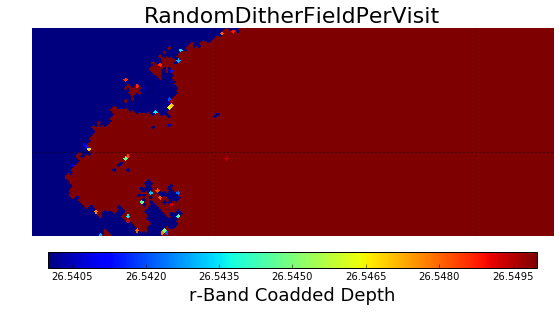

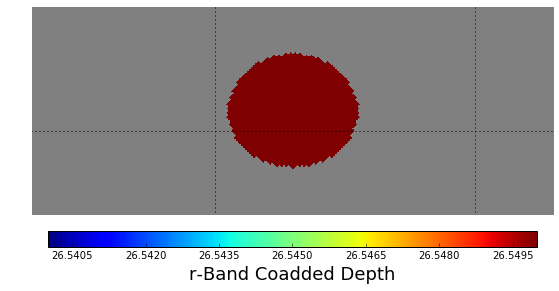

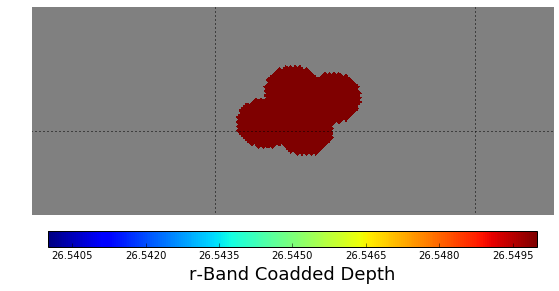

In [9]:
focusDither= 'RandomDitherFieldPerVisit'
colorMin, colorMax= 26.54, 26.55

check= copy.deepcopy(coaddBundle[focusDither])

raRange= [np.degrees(fiducialRA)-20,np.degrees(fiducialRA)+20]
decRange= [np.degrees(fiducialDec)-8,np.degrees(fiducialDec)+8]

# plot the actual coadded depth. zoomed in.
plt.clf()
hp.cartview(coaddBundle[focusDither].metricValues.filled(coaddBundle[focusDither].slicer.badval), 
            flip='astro', rot=(0,0,0) ,
            lonra= raRange, latra= decRange,
            min= colorMin, max= colorMax, title= '', cbar=False)
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.title(focusDither, size= 22)
ax = plt.gca()
im = ax.get_images()[0]
fig= plt.gcf()
cbaxes = fig.add_axes([0.1, 0.15, 0.8, 0.04]) # [left, bottom, width, height]
cb = plt.colorbar(im,  orientation='horizontal',
            format= '%.4f', cax = cbaxes) 
cb.set_label('r-Band Coadded Depth', fontsize=18)
plt.show()


# plot only the disk region. everything else= masked.
check.metricValues.mask[:]= True
check.metricValues.mask[discPixels]= False

plt.clf()
hp.cartview(check.metricValues.filled(check.slicer.badval), 
            flip='astro', rot=(0,0,0) ,
            lonra= raRange, latra= decRange,
            min= colorMin, max= colorMax, title= '', cbar=False)
hp.graticule(dpar=20, dmer=20, verbose=False)
ax = plt.gca()
im = ax.get_images()[0]
fig= plt.gcf()
cbaxes = fig.add_axes([0.1, 0.15, 0.8, 0.04]) # [left, bottom, width, height]
cb = plt.colorbar(im,  orientation='horizontal',
            format= '%.4f', cax = cbaxes) 
cb.set_label('r-Band Coadded Depth', fontsize=18)
plt.show()

# plot only the compact nonDisk region. everything else= masked.
check.metricValues.mask[:]= True
check.metricValues.mask[nondiscPixels]= False
plt.clf()
hp.cartview(check.metricValues.filled(check.slicer.badval), 
            flip='astro', rot=(0,0,0) ,
            lonra= raRange, latra= decRange,
            min= colorMin, max= colorMax, title= '', cbar=False)
hp.graticule(dpar=20, dmer=20, verbose=False)
ax = plt.gca()
im = ax.get_images()[0]
fig= plt.gcf()
cbaxes = fig.add_axes([0.1, 0.15, 0.8, 0.04]) # [left, bottom, width, height]
cb = plt.colorbar(im,  orientation='horizontal',
            format= '%.4f', cax = cbaxes) 
cb.set_label('r-Band Coadded Depth', fontsize=18)
plt.show()

#### Plot some other things.

In [10]:
help(buildAndPlotRegion)

Help on function buildAndPlotRegion in module plotFunctions:

buildAndPlotRegion(fID, simdata, coaddBundle, FOV_radius, pixels_in_FOV, focusDither=None, nside=256, disc=False)
    Find the region (disc or rectangular) based on the specified field ID and plot it (full survey
    region and a zoomed in version).
    
    Required Parameters
    -------------------
    * fID: int: fieldID for the FOV on which to base the region.
    * simdata: np.array: array containing OpSim columns (must have fieldID, fieldRA, fieldDec).
    * coaddBundle: dict: dictionary with keys= observing strategy names, pointing to corresponding
                         to a metricBundle object.
    * FOV_radius: float: radius of the FOV in radians.
    * pixels_in_FOV: dict: dictionary with keys= dither strategy. Each key points to a dictionary with
                           keys= field ID, pointing to the list of HEALPix pixels
                           that fall in the FOV.
    
    Optional Parameters
    --

In [11]:
pixelNum= getSurveyHEALPixRADec(coaddBundle)
pixels_in_FOV= getFOVsHEALPixReln(pixelNum, simdata, nside= 256)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Number of fieldIDs in pixel_in_FOV for RandomDitherFieldPerVisit: 2250


Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
FID List for RandomDitherFieldPerVisit: [1212, 1220, 1234, 1305, 1323, 1333, 1365, 1413, 1431, 1447, 1464, 1506, 1542, 1564, 1568]

## Grey (masked) pixel was inputted in the query_ function.


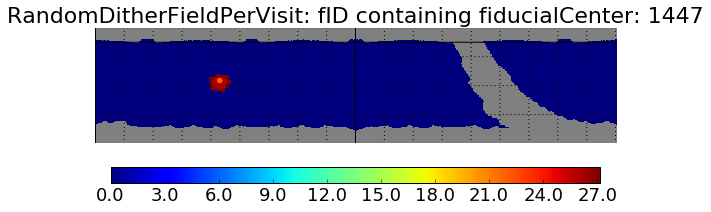

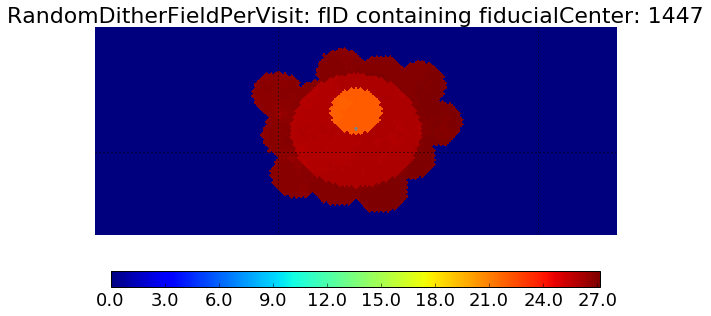

In [12]:
buildAndPlotRegion(fID, simdata, coaddBundle, FOV_radius= 0.0305, 
                   focusDither= focusDither,
                   pixels_in_FOV= pixels_in_FOV, 
                   disc= True)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
FID List for RandomDitherFieldPerVisit: [1212, 1220, 1234, 1305, 1323, 1333, 1365, 1413, 1431, 1447, 1464, 1542, 1564, 1568]

## Grey (masked) pixel was inputted in the query_ function.


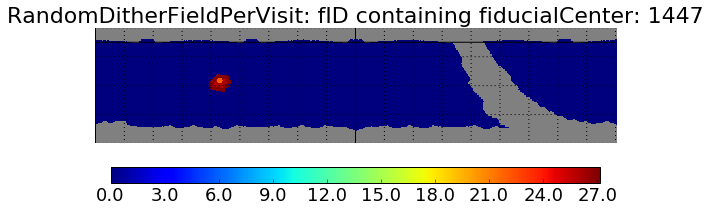

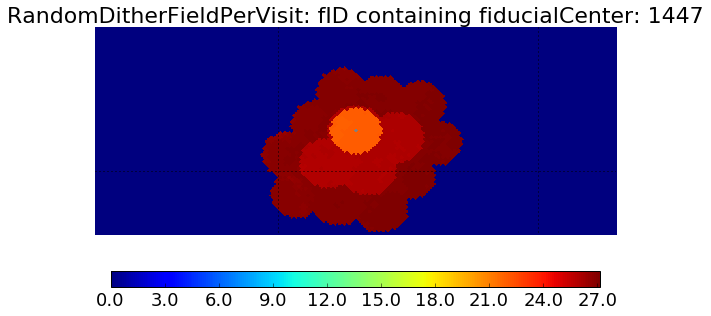

In [13]:
buildAndPlotRegion(fID, simdata, coaddBundle, FOV_radius= 0.0305, 
                   focusDither= focusDither,
                   pixels_in_FOV= pixels_in_FOV, 
                   disc= False)